# Grover's Search Algorithm


Grover's algorithm is arguably one of the canonical quantum algorithms that kick-started the field of quantum computing. In the future, it could possibly serve as a hallmark application of quantum computing. Grover's algorithm allows us to find a particular register in an unordered database with $N$ entries in just $O(\sqrt{N})$ steps, compared to the best classical algorithm taking on average $N/2$ steps, thereby providing a **quadratic speedup**. For large databases (with a large number of entries, $N$), a quadratic speedup can provide a significant advantage. For a database with one million entries, a quantum computer running Grover's algorithm would need about 1000 runs, while a classical computer would need, on average, $500,000$ runs.

In this notebook, we implement Gover's algorithm based on ion-trap experiments [1]. In particular, we implement the phase oracle (see Figure 1d and 1e of this paper). For a compherensive description of the algorithm see Chapter 6 of [2]. In the ion-trap experiments [1], the oracle encodes bitstrings with length three. Here, we extend the bitstrings to arbitrary length. We use generalized Toffoli gates to construct the oracle. Following reference [3], the generalized Toffoli gates is decomposed into Toffoli gates.

---

# References <a name="ref"></a>

[1] C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017). "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, doi:10.1038/s41467-017-01904-7. [arXiv:1703.10535](https://arxiv.org/abs/1703.10535).

[2] Nielsen, Michael A., Chuang, Isaac L. (2010). Quantum Computation and Quantum Information (2nd ed.). Cambridge: Cambridge University Press.

[3] J. M. Baker, C. Duckering, A. Hoover, F. T. Chong (2019). Decomposing Quantum Generalized Toffoli with an Arbitrary Number of Ancilla. [arXiv:1904.01671](https://arxiv.org/abs/1904.01671).


In [2]:
# モジュールを強制的にリロード
import sys

# 既にロードされているモジュールを削除
if "braket.experimental.algorithms.grovers_search" in sys.modules:
    del sys.modules["braket.experimental.algorithms.grovers_search"]
if "braket.experimental.algorithms.grovers_search.grovers_search" in sys.modules:
    del sys.modules["braket.experimental.algorithms.grovers_search.grovers_search"]

from notebook_plotting import plot_bitstrings_formatted
import numpy as np

%matplotlib inline

from braket.aws import AwsDevice
from braket.devices import LocalSimulator

from braket.experimental.algorithms.grovers_search import (
    build_oracle,
    grovers_search,
    grovers_search_step_by_step,  # 新しい関数をインポート
)
import math

print("✓ インポート成功！")

✓ インポート成功！


In [19]:
solution = "100"
n_qubits = len(solution)

oracle = build_oracle(solution)
circuit = grovers_search(oracle, n_qubits=n_qubits, n_reps=1)

print("number of data qubits: ", n_qubits)
print("number of ancilla qubits: ", circuit.qubit_count - n_qubits)
print(circuit)

number of data qubits:  3
number of ancilla qubits:  3
T  : │  0  │     1     │  2  │  3  │     4     │  5  │  6  │     7     │  8  │  9  │    10     │ 11  │ 12  │ Result Types  │
      ┌───┐                                     ┌───┐ ┌───┐                                     ┌───┐ ┌───┐ ┌─────────────┐ 
q0 : ─┤ H ├─────────●───────────────────────●───┤ H ├─┤ X ├─────────●───────────────────────●───┤ X ├─┤ H ├─┤ Probability ├─
      └───┘         │                       │   └───┘ └───┘         │                       │   └───┘ └───┘ └──────┬──────┘ 
      ┌───┐ ┌───┐   │                       │   ┌───┐ ┌───┐ ┌───┐   │                       │   ┌───┐ ┌───┐ ┌──────┴──────┐ 
q1 : ─┤ H ├─┤ X ├───┼─────●───────────●─────┼───┤ X ├─┤ H ├─┤ X ├───┼─────●───────────●─────┼───┤ X ├─┤ H ├─┤ Probability ├─
      └───┘ └───┘   │     │           │     │   └───┘ └───┘ └───┘   │     │           │     │   └───┘ └───┘ └──────┬──────┘ 
      ┌───┐ ┌───┐   │     │           │     │   ┌───┐ ┌───┐ ┌───┐   │ 

# Run on a local simulator

We demonstrate Grover's algorithm on a classical simulator first. You can choose between a local simulator or an on-demand simulator.


# Visualize State Vector at Each Time Step

Using LocalSimulator, we track the state vector and probability distribution after each gate application in the circuit.


In [20]:
# Create a small circuit and track each step
solution_small = "11"
n_qubits_small = len(solution_small)

oracle_small = build_oracle(solution_small)

# Use the new function to get circuits for each step
step_circuits = grovers_search_step_by_step(oracle_small, n_qubits=n_qubits_small, n_reps=1)

print(f"Number of steps obtained: {len(step_circuits)}")
print(f"  - Step 0: Initial state (after H gates)")
print(f"  - Step 1: After Oracle application")
print(f"  - Step 2: After Amplification")


# Function to calculate data qubit probabilities only
def get_data_qubit_probabilities(state_vector, n_data_qubits, total_qubits):
    """
    Calculate probability distribution of data qubits only from state vector
    by tracing out ancilla qubits
    """
    state_array = np.array(state_vector)

    # Calculate probability distribution of data qubits (trace out ancilla)
    data_probs = np.zeros(2**n_data_qubits)
    for i in range(2**total_qubits):
        # Extract data qubit index
        data_idx = i % (2**n_data_qubits)
        data_probs[data_idx] += abs(state_array[i]) ** 2

    return data_probs

Number of steps obtained: 3
  - Step 0: Initial state (after H gates)
  - Step 1: After Oracle application
  - Step 2: After Amplification


In [21]:
# Run each step circuit and obtain states
local_sim = LocalSimulator()

states_over_time = []

print("Running simulation for each step...")
for step_idx, circuit in enumerate(step_circuits):
    result = local_sim.run(circuit, shots=0).result()
    state_vector = result.values[0]

    # Calculate data qubit probabilities
    total_qubits = circuit.qubit_count
    probs = get_data_qubit_probabilities(state_vector, n_qubits_small, total_qubits)
    states_over_time.append((step_idx, probs))

    print(f"  Step {step_idx} completed")

print(f"\nSimulation complete! Obtained data for {len(states_over_time)} steps.")

# Display states
print(f"\nProbability distribution at each step:")
for step, probs in states_over_time:
    print(f"\nStep {step}:")
    for i, prob in enumerate(probs):
        bitstring = format(i, f"0{n_qubits_small}b")
        print(f"  |{bitstring}⟩: {prob:.4f}")

Running simulation for each step...
  Step 0 completed
  Step 1 completed
  Step 2 completed

Simulation complete! Obtained data for 3 steps.

Probability distribution at each step:

Step 0:
  |00⟩: 0.2500
  |01⟩: 0.2500
  |10⟩: 0.2500
  |11⟩: 0.2500

Step 1:
  |00⟩: 0.5000
  |01⟩: 0.0000
  |10⟩: 0.5000
  |11⟩: 0.0000

Step 2:
  |00⟩: 0.0000
  |01⟩: 0.0000
  |10⟩: 1.0000
  |11⟩: 0.0000



Visualizing state evolution...


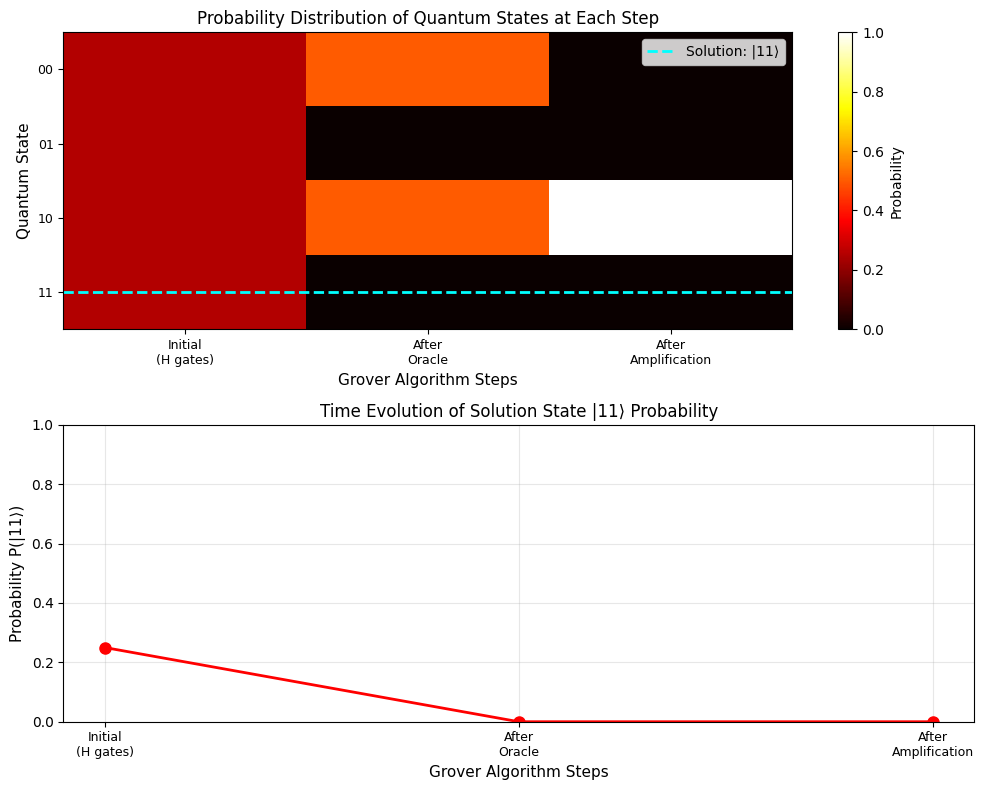

In [22]:
# Visualize state evolution at each step
import matplotlib.pyplot as plt


def plot_state_evolution(states_over_time, solution_state):
    """
    Visualize state evolution as a heatmap

    Args:
        states_over_time: List of (time, probability distribution) tuples
        solution_state: Solution state (bit string)
    """
    if not states_over_time:
        print("No data to display")
        return

    n_steps = len(states_over_time)
    n_states = len(states_over_time[0][1])
    n_qubits = int(np.log2(n_states))

    # Convert data to matrix
    prob_matrix = np.array([probs for _, probs in states_over_time]).T

    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Heatmap
    im = ax1.imshow(prob_matrix, aspect="auto", cmap="hot", interpolation="nearest")
    ax1.set_xlabel("Grover Algorithm Steps", fontsize=11)
    ax1.set_ylabel("Quantum State", fontsize=11)
    ax1.set_title("Probability Distribution of Quantum States at Each Step", fontsize=12)

    # x-axis labels
    step_labels = ["Initial\n(H gates)", "After\nOracle", "After\nAmplification"]
    ax1.set_xticks(range(n_steps))
    ax1.set_xticklabels(step_labels[:n_steps], fontsize=9)

    # y-axis labels as bit strings
    bitstrings = [format(i, f"0{n_qubits}b") for i in range(n_states)]
    ax1.set_yticks(range(n_states))
    ax1.set_yticklabels(bitstrings, fontsize=9)

    # Highlight solution state
    solution_idx = int(solution_state, 2)
    ax1.axhline(
        y=solution_idx,
        color="cyan",
        linestyle="--",
        linewidth=2,
        label=f"Solution: |{solution_state}⟩",
    )
    ax1.legend(loc="upper right", fontsize=10)

    plt.colorbar(im, ax=ax1, label="Probability")

    # Time evolution of solution state probability
    solution_probs = [probs[solution_idx] for _, probs in states_over_time]
    ax2.plot(range(n_steps), solution_probs, "o-", linewidth=2, markersize=8, color="red")
    ax2.set_xlabel("Grover Algorithm Steps", fontsize=11)
    ax2.set_ylabel(f"Probability P(|{solution_state}⟩)", fontsize=11)
    ax2.set_title(f"Time Evolution of Solution State |{solution_state}⟩ Probability", fontsize=12)
    ax2.set_xticks(range(n_steps))
    ax2.set_xticklabels(step_labels[:n_steps], fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1.0])

    plt.tight_layout()
    plt.show()


# Execute visualization
print("\nVisualizing state evolution...")
plot_state_evolution(states_over_time, solution_small)

## Interpretation of Results

The graphs above show:

1. **Heatmap (top)**: Probability distribution of all quantum states at each step

   - X-axis: Time (Grover algorithm steps)
   - Y-axis: Quantum states (bit strings)
   - Color: Probability magnitude (redder = higher probability)
   - Cyan dashed line: Solution state

2. **Time series plot (bottom)**: Time evolution of solution state probability
   - As Grover's algorithm progresses, the probability of the solution state increases
   - Initial state: All states have equal probability (1/2^n)
   - Oracle + Diffusion (Amplification) operations amplify the solution state probability


# 各時刻 T での状態を追跡

# 回路を段階的に構築して実行

def simulate_circuit_step_by_step(circuit, n_data_qubits, max_steps=None):
"""
回路を段階的に実行して各時刻（深さ）での状態を取得

    Args:
        circuit: 実行する回路
        n_data_qubits: データqubitの数
        max_steps: 追跡する最大ステップ数（Noneの場合は全て）

    Returns:
        各時刻での確率分布のリスト
    """
    local_sim = LocalSimulator()
    total_qubits = circuit.qubit_count
    max_depth = circuit.depth if max_steps is None else min(circuit.depth, max_steps)

    states_over_time = []

    # 各深さ（時刻T）での状態を取得
    for target_depth in range(max_depth + 1):
        # 現在の深さまでの部分回路を作成
        partial_circuit = Circuit()

        # 各instructionの深さを計算しながら追加
        current_depth = 0
        for instruction in circuit.instructions:
            # このinstructionを追加した時の深さを計算
            # 簡易的な実装：各命令が深さ1を追加すると仮定
            if current_depth > target_depth:
                break

            partial_circuit.add_instruction(instruction)
            current_depth += 1

        # StateVectorを追加して実行
        partial_circuit.state_vector()

        try:
            result = local_sim.run(partial_circuit, shots=0).result()
            state_vector = result.values[0]

            # データqubitの確率を計算
            probs = get_data_qubit_probabilities(state_vector, n_data_qubits, total_qubits)
            states_over_time.append((target_depth, probs))

            if target_depth % 5 == 0:  # 進捗表示
                print(f"  深さ {target_depth}/{max_depth} 完了")
        except Exception as e:
            print(f"Error at depth {target_depth}: {e}")
            break

    return states_over_time

# 小さい回路で試す（計算量が少ない）

print("各時刻 T での状態遷移を計算中...")
states = simulate_circuit_step_by_step(circuit_with_states, n_qubits_small, max_steps=20)

print(f"\n 最初の{min(len(states), 5)}ステップの状態:")
for t, probs in states[:5]: # 最初の 5 ステップを表示
print(f"\nT={t}:")
for i, prob in enumerate(probs):
bitstring = format(i, f'0{n_qubits_small}b')
if prob > 0.01: # 確率が 1%以上のものだけ表示
print(f" |{bitstring}⟩: {prob:.4f}")

print(f"\n 計算完了！全{len(states)}ステップのデータを取得しました。")


In [276]:
# task = local_simulator.run(circuit, shots=1000)
# print(task)

In [277]:
# plot_bitstrings_formatted(probabilities)

# Run on a QPU or an on-demand simulator

Now we run on IonQ. Toffoli gate (CCNot) is not a supported gate of IonQ device. We use the `decompose_ccnot=True` to decompose the Toffoli gate into CNot, Ti, T and H gates.


In [17]:
# device = AwsDevice("arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet")  # IQM - Garnet
# device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")  # QuEra - Aquila
# device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3")  # Rigetti - Ankaa-3
device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Forte-1")  # IonQ - Forte-1
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")  # on-demand simulator

In [18]:
from braket.tracking import Tracker

tracker = Tracker().start()

print(f"状態: {device.status}")  # ONLINEか確認
print(f"キュー: {device.queue_depth().quantum_tasks}件待ち")

状態: OFFLINE
キュー: {<QueueType.NORMAL: 'Normal'>: '89', <QueueType.PRIORITY: 'Priority'>: '0'}件待ち


In [19]:
solution = "111"
# solution = "11111"
n_qubits = len(solution)

# oracle = build_oracle(solution)
# circuit = grovers_search(oracle, n_qubits=n_qubits, n_reps=5)
oracle = build_oracle(solution, decompose_ccnot=True)
# print("number of data qubits: ", n_qubits)
# print("number of ancilla qubits: ", circuit.qubit_count - n_qubits)
# print(circuit)

# 最適な反復回数
r = round(math.pi / 4 * math.sqrt(2**n_qubits))
# r = 10

# for i in range(1, r + 2 + 1):
#     # oracle = build_oracle(solution, decompose_ccnot=True)
#     circuit_qpu = grovers_search(oracle, n_qubits=n_qubits, n_reps=i, decompose_ccnot=True)
#     qpu_task = device.run(circuit_qpu, shots=1000)
#     qpu_result = qpu_task.result()
#     probabilities = qpu_result.values[0]
#     print(i, ":", probabilities[-1])

circuit_qpu = grovers_search(oracle, n_qubits=n_qubits, n_reps=r, decompose_ccnot=True)
qpu_task = device.run(circuit_qpu, shots=1000)
qpu_result = qpu_task.result()
probabilities = qpu_result.values[0]
print(r, ":", probabilities)

DeviceOfflineException: An error occurred (DeviceOfflineException) when calling the CreateQuantumTask operation: Device is not available. Status = OFFLINE

In [300]:
# qpu_result = qpu_task.result()
# probabilities = qpu_result.values[0]
# print(probabilities)

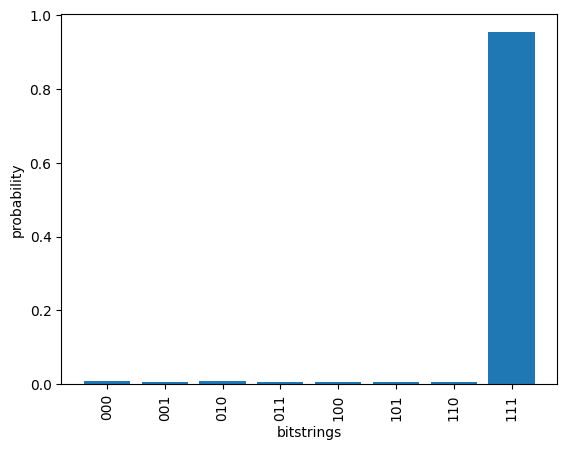

In [301]:
plot_bitstrings_formatted(probabilities)

In [284]:
print("Task Summary")
print(f"{tracker.quantum_tasks_statistics()} \n")
print(
    f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD"
)

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 5000, 'tasks': {'COMPLETED': 5}, 'execution_duration': datetime.timedelta(microseconds=73000), 'billed_execution_duration': datetime.timedelta(seconds=15)}} 

Estimated cost to run this example: 0.02 USD


Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
